In [151]:
#conda install -c conda-forge pyarrow

In [152]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

# Librairies

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [154]:
from multiprocessing import Pool
import os
cpuCount = os.cpu_count()
cpuCount

12

In [155]:
db = pd.read_parquet('db_P4.parquet.gzip')
Energy_Star_Score = db[['OSEBuildingID','ENERGYSTARScore']]
db = db.drop(columns=['log_SiteEnergyUseWN(kBtu)']) # On supprime la cible 2 pour éviter toute confusion
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
Energy_Star_Score # On le conserve pour le tester sur notre modèle final

,OSEBuildingID,ENERGYSTARScore
0,1,60.0
1,2,61.0
2,3,43.0
3,5,56.0
4,8,75.0
...,...,...
1478,50221,NaN
1479,50223,NaN
1480,50224,NaN
1481,50225,NaN


# Variables prédictives X & Cible y 

In [157]:
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import explained_variance_score,mean_absolute_error, r2_score,  mean_squared_error

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import xgboost as xgb

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

from time import time


In [158]:
features_names = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy().columns
features_names = list(features_names)
len(features_names)

40

In [178]:
X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = X.fillna(0)
X.isna().mean()

Latitude                                           0.0
Longitude                                          0.0
YearBuilt                                          0.0
NumberofBuildings                                  0.0
NumberofFloors                                     0.0
per_gfa_parking                                    0.0
per_gfa_bulding                                    0.0
site_per_electricity                               0.0
site_per_steam                                     0.0
site_per_gaz                                       0.0
Bank Branch                                        0.0
College/University                                 0.0
Data Center                                        0.0
Distribution Center                                0.0
Fitness Center/Health Club/Gym                     0.0
Food Service                                       0.0
Hospital (General Medical & Surgical)              0.0
Hotel                                              0.0
K-12 Schoo

In [179]:
#X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = np.array(X)
X.shape

(1483, 40)

In [180]:
y = db['log_TotalGHGEmissions'].copy()
y = np.array(y)
y.shape

(1483,)

# Train & Test Split

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2023)

# Modèle 

In [182]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror' ,n_jobs= -1)
lg = lgb.LGBMRegressor(n_jobs=-1)
Svr = SVR(C=.05, epsilon=0.2)

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    xg_reg,
    lg,
    SGDRegressor(),
    Svr
    
    
]

In [183]:
#head = 11
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 0.007s
	Explained variance: 0.2723362025202417
	Mean absolute error: 0.9932987420354836
	R2 score: 0.25992335964308266

GradientBoostingRegressor()
	Training time: 0.221s
	Prediction time: 0.001s
	Explained variance: 0.6395340356867977
	Mean absolute error: 0.6920538343626054
	R2 score: 0.6376800818546495

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.006s
	Explained variance: 0.2723362025202417
	Mean absolute error: 0.9932987420354836
	R2 score: 0.25992335964308266

ExtraTreesRegressor()
	Training time: 0.429s
	Prediction time: 0.011s
	Explained variance: 0.6300503946266824
	Mean absolute error: 0.693150384099461
	R2 score: 0.6220037915450383

RandomForestRegressor()
	Training time: 0.548s
	Prediction time: 0.000s
	Explained variance: 0.6123422365006834
	Mean absolute error: 0.71643266056307
	R2 score: 0.6078858469320719

DecisionTreeRegressor()
	Training time: 0.019s
	Prediction time: 0.000s
	Explained 

# Fonction ML avec cross validation 
    Comparer les modèles

In [184]:
# Fonction 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def ML (model, X = X_train, y = y_train, param = None):
    
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

    if param is not None:
        
        gs = GridSearchCV(model, param_grid = param, cv = kfold, scoring = 'r2').fit(X,y)
        print(gs.best_params_)
        model.set_params(**gs.best_params_)
    
    list_pred = []
    list_val = []

    start = time()
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)
    
    for train, test in kfold:
        list_pred.append(model.fit(X[train],y[train]).predict(X[test]))
        list_val.append(y[test])
        
    end = time()
    
    list_pred = np.concatenate(list_pred)
    list_val = np.concatenate(list_val)


    print('\n',model,
                 '\n MSE : ', mean_squared_error(list_pred,list_val),
                 '\n R2 : ', r2_score(list_pred,list_val),
                 '\n Prédictions : ' , list_pred[:10], 
                 '\n Valeurs : ' , list_val[:10],
                 '\n Time' , end-start) 
    
    result = {'model' : model,
            'MSE' : mean_squared_error(list_pred,list_val),
            'R2' : r2_score(list_pred,list_val),
            'Prédictions' : list_pred,
            'Valeurs' : list_val,
            'Time' : end-start
             }
    
    if param is not None : 
        result['Best Params'] = gs.best_params_ 

    return result
                

###  Test 

In [185]:
test = ML(LinearRegression()) #OK !


 LinearRegression() 
 MSE :  1.0334293553457061 
 R2 :  0.24749406079913805 
 Prédictions :  [2.98340011 3.66869116 3.17650279 3.02180879 4.60629518 3.75559019
 3.19450211 2.7812766  2.68209357 2.58407083] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.006897449493408203


In [ ]:
#test

In [186]:
for model in regressors:
    ML(model)


 KNeighborsRegressor() 
 MSE :  1.6768410178818984 
 R2 :  -1.1998352321935126 
 Prédictions :  [3.81602769 3.92666556 3.56929036 3.88927657 4.18143666 3.53361595
 3.37539406 3.03907487 3.58936624 2.14885032] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.022716760635375977

 GradientBoostingRegressor() 
 MSE :  0.7424838286411174 
 R2 :  0.40173942650802874 
 Prédictions :  [4.64832173 3.91511617 3.21094354 4.05482683 5.75008777 3.6680545
 3.54451605 2.46812076 2.14146551 2.17653724] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.758495569229126

 KNeighborsRegressor() 
 MSE :  1.6768410178818984 
 R2 :  -1.1998352321935126 
 Prédictions :  [3.81602769 3.92666556 3.56929036 3.88927657 4.18143666 3.53361595
 3.37539406 3.03907487 3.58936624 2.14885032] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.

### ZIP avec Hyper Paramètres

In [187]:
model_list = [LinearRegression(),
              RandomForestRegressor(n_jobs= -1), # Parallélisation tous les CPU -1 
              xgb.XGBRegressor(n_jobs= -1 ),
              lgb.LGBMRegressor(n_jobs= -1)
             ]

params_list =  [None, # LinearRegressioin
                {'n_estimators' : [80, 100, 120] , # RF
                 'max_depth': [5, 10, 20, 25],
                 'min_samples_split': [2, 5, 8, 10],
                 'min_samples_leaf': [1, 2, 5]
                },
                { 'n_estimators' : [50,100,1000], # XGB
                 'max_depth' : [5, 10, 20],
                 'eta' : [0.01,0.1,0.5],
                 'subsample': [0.3,0.5,0.7],
                 'colsample_bytree' : [0.3,0.5,0.7]
                },
                {'n_estimators': [80, 100, 120, 150], # LGBM
                 'max_depth': [3, 5, 8, 10],
                 'num_leaves': [6, 8, 10]
                }
                
               
               ]



#zip_object = zip(model_list,params_list)


In [188]:
res = []
for model,param in zip(model_list,params_list):
    res.append(ML(model=model,param=param))


 LinearRegression() 
 MSE :  1.0334293553457061 
 R2 :  0.24749406079913805 
 Prédictions :  [2.98340011 3.66869116 3.17650279 3.02180879 4.60629518 3.75559019
 3.19450211 2.7812766  2.68209357 2.58407083] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.02507305145263672
{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 120}

 RandomForestRegressor(max_depth=25, min_samples_split=5, n_estimators=120,
                      n_jobs=-1) 
 MSE :  0.7789055489099662 
 R2 :  0.39686478761315536 
 Prédictions :  [4.15841348 3.85388472 3.26744893 4.21615467 5.82415465 3.4890253
 3.10903233 2.47640867 2.04675801 2.38987157] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.7048637866973877
{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}

 XGBRegress

# PLot

## Meilleur modèle en fonction des métriques R2 MSE

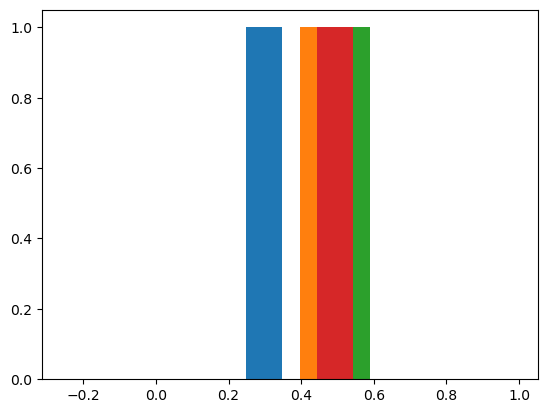

In [189]:
plt.figure()
plt.hist(res[0]['R2'])
plt.hist(res[1]['R2'])
plt.hist(res[2]['R2'])
plt.hist(res[3]['R2'])
plt.show()

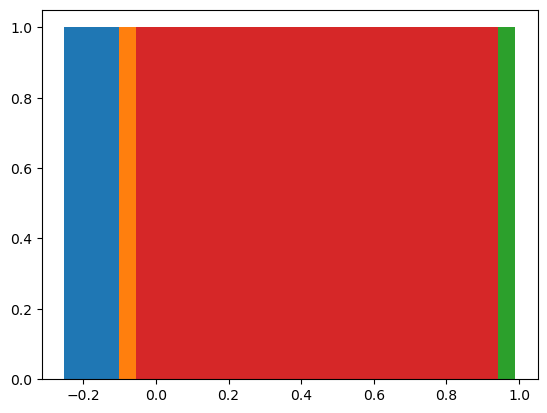

In [190]:
list_res = [0,1,2,3]
for i in list_res:
    plt.hist(res[i]['R2'],height=1)

In [191]:
list_res = [0,1,2,3]
for i in list_res:
        print('\n',res[i]['model'],
             '\n','MSE :',res[i]['MSE'],
             '\n','R2 :',res[i]['R2'])



 LinearRegression() 
 MSE : 1.0334293553457061 
 R2 : 0.24749406079913805

 RandomForestRegressor(max_depth=25, min_samples_split=5, n_estimators=120,
                      n_jobs=-1) 
 MSE : 0.7789055489099662 
 R2 : 0.39686478761315536

 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...) 
 MSE : 0.6749245898697543 
 R2 

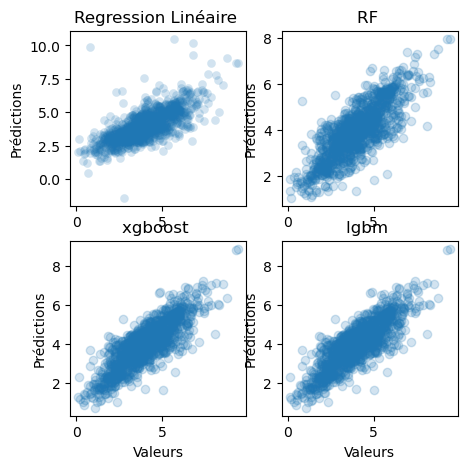

In [192]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)

plt.scatter(res[0]['Valeurs'],res[0]['Prédictions'],alpha=0.2, linewidths = .1)
plt.title('Regression Linéaire ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,2)

plt.scatter(res[1]['Valeurs'],res[1]['Prédictions'],alpha=0.2)
plt.title('RF ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,3)

plt.scatter(res[2]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
plt.title('xgboost ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.subplot(2,2,4)

plt.scatter(res[3]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
#plt.plot(res[3]['Valeurs'],res[2]['Prédictions'])
plt.title('lgbm ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.show()



# Final model 

In [ ]:
# best_parameters = max_depth=3, n_estimators=150, num_leaves=8

In [ ]:
final_model = lgb.LGBMRegressor(max_depth=3, n_estimators=150, num_leaves=8, n_jobs=-1)

In [ ]:
final_model.fit(X_train,y_train)

In [ ]:
pred = final_model.predict(X_test)

In [ ]:
import seaborn as sns
sns.scatterplot(x= y_test , y=pred)
plt.show()

In [ ]:
mean_squared_error(pred,y_test),r2_score(pred,y_test)

# final XGB 

In [193]:
final_xgb =  xgb.XGBRegressor( max_depth=3, n_estimators=150,n_jobs= -1) 

In [194]:
final_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [195]:
pred_xgb = final_xgb.predict(X_test)

In [196]:
mean_squared_error(pred_xgb,y_test),r2_score(pred_xgb,y_test)

(0.7946796377438495, 0.39931381059885884)

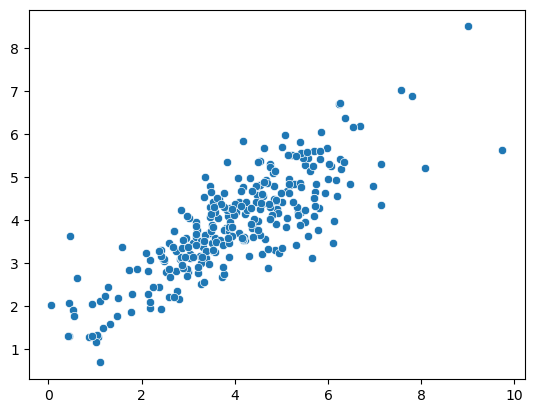

In [197]:
sns.scatterplot(x= y_test , y=pred_xgb)
plt.show()

# SHAP 

In [ ]:
#conda install -c conda-forge shap

In [198]:
import shap 

In [199]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [200]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

## Shap Features Importances

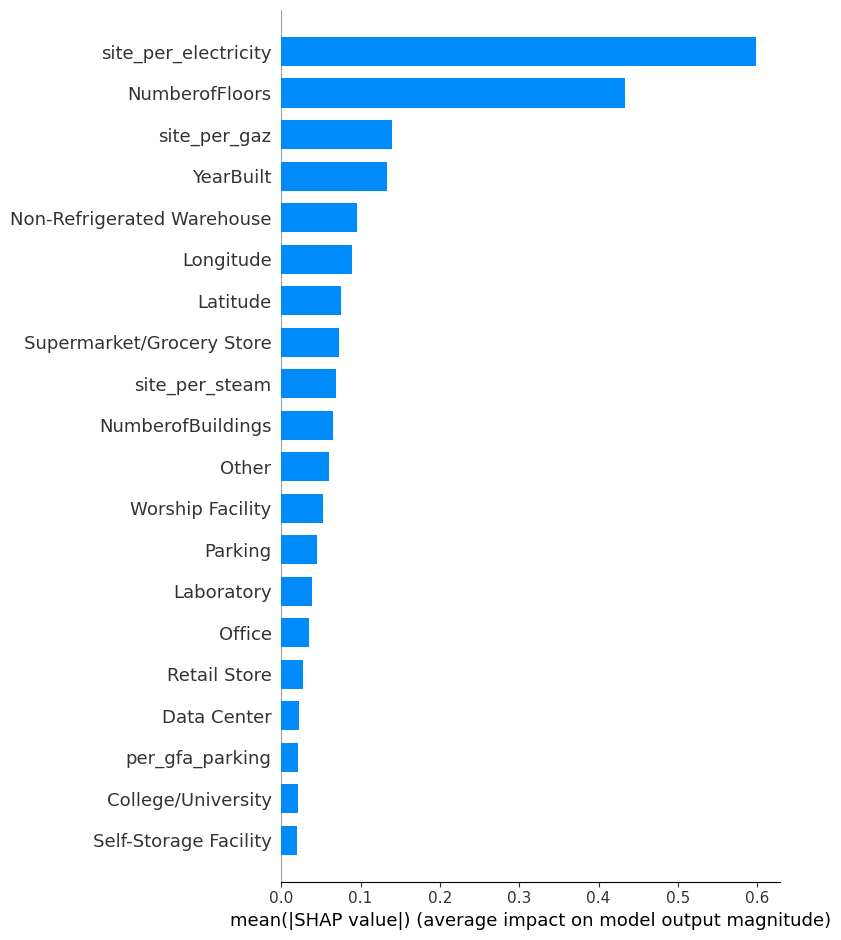

In [201]:
shap_values = shap.TreeExplainer(final_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=features_names)

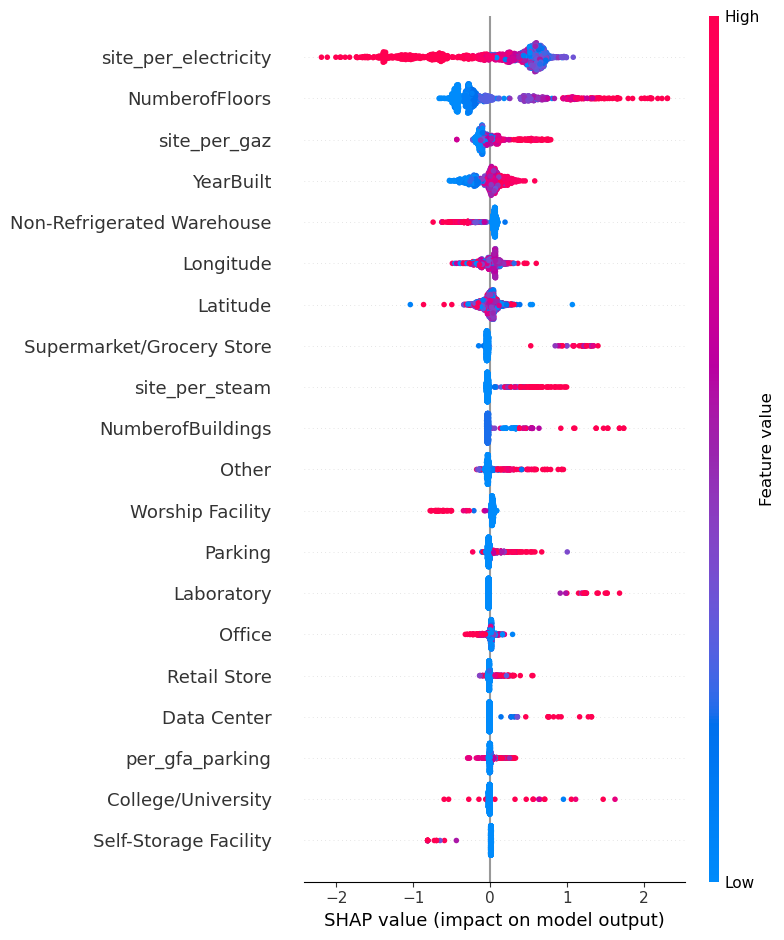

In [203]:
shap.summary_plot(shap_values, X_train,feature_names=features_names)

# Energy Star Score 
    On ajoute aux features X energy Star Score
    y demeure log TotalGHGEmission
    On test sur un train test notre meilleur modèle XGB avec les hyper paramètres selectionnés

In [212]:
X_Star_Score = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID']).copy() 
X_Star_Score = X_Star_Score.dropna()

In [213]:
# On conserve cette fois ci Energy Star Score 
# y demeure inchangé
#X_Star_Score = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID']).copy() 
X_Star_Score = np.array(X_Star_Score)
X_Star_Score

array([[  47.6122 , -122.33799, 1927.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.61317, -122.33393, 1996.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.61393, -122.3381 , 1969.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [  47.54425, -122.31776, 1955.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.53161, -122.29944, 1929.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.58831, -122.3065 , 2015.     , ...,    0.     ,    0.     ,
           0.     ]])

In [214]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_Star_Score, y, test_size=0.2 , random_state = 2023)

ValueError: Found input variables with inconsistent numbers of samples: [946, 1483]

In [206]:
final_xgb.fit(X_train_2,y_train_2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [207]:
pred_star_score = final_xgb.predict(X_test_2)

In [208]:
print('MSE : ', mean_squared_error(pred_star_score,y_test_2),'\n',
      'R2 : ',r2_score(pred_star_score,y_test_2))

MSE :  0.7069780682553608 
 R2 :  0.48249243807002895


In [ ]:
sns.scatterplot(x= y_test_2 , y=pred_star_score)
plt.show()

In [ ]:
plt.plot(pred_star_score-y_test_2)
plt.show()

- Beaucoup mieux avec Energy Star Score 

# Prédiction uniquement avec une adresse postale ? 
    Scénario OpenClassrooms : Question de Douglas : Peut-on déduire des choses intérressantes d'une simple adresse ?
    - Prenons notre modèle final_xgb
    - entrainnons le sur X : var = Latitude et Longitude

In [ ]:
db

In [ ]:
db[['Latitude','Longitude']]

In [ ]:
# On conserve cette fois ci les variables/features Latitude et Longitude
# y demeure inchangé
X_simple_address = db[['Latitude','Longitude']].copy() 
X_simple_address = np.array(X_simple_address)
X_simple_address

In [ ]:
X_train_address, X_test_address, y_train_address, y_test_address = train_test_split(X_simple_address, y, test_size=0.2 , random_state = 2023)

In [ ]:
final_xgb.fit(X_train_address,y_train_address)

In [ ]:
pred_simple_address = final_xgb.predict(X_test_address)

In [ ]:
print('MSE : ', mean_squared_error(pred_simple_address,y_test_address),'\n',
      'R2 : ',r2_score(pred_simple_address,y_test_address))

In [ ]:
sns.scatterplot(x= y_test_address , y= pred_simple_address,lw=2)
plt.show()

In [ ]:
plt.plot(pred_simple_address-y_test_address)
plt.show()

Résultat peu convaincant 